<a href="https://www.kaggle.com/code/sanhithreddy/car-price-by-rf?scriptVersionId=260844720" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Car Price Prediction Challenge



In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

ZIP_PATH = '/mnt/data/car_price_prediction.csv.zip'
MODEL_OUT = '/mnt/data/car_price_model_final.pkl'
CLEANED_OUT = '/mnt/data/car_price_cleaned_full.csv'

In [2]:
df=pd.read_csv("/kaggle/input/car-price-prediction-challenge/car_price_prediction.csv")
df.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


## Data cleaning & preprocessing



In [3]:
# Data cleaning code
orig_cols = df.columns.tolist()
df.columns = [c.strip().replace(' ', '_').replace('.', '').replace('/', '_') for c in df.columns]
print('Columns normalized')

for col in df.columns:
    if df[col].dtype == object:
        cleaned = df[col].astype(str).str.replace(',', '').str.replace('₹', '').str.replace('$', '').str.replace('€','').str.strip()
        coerced = pd.to_numeric(cleaned, errors='coerce')
        if coerced.notna().sum() / len(df) > 0.3:
            df[col] = coerced
            print('Converted to numeric:', col)

possible_prod_cols = [c for c in df.columns if 'prod' in c.lower() or 'year' in c.lower()]
current_year = 2025
prod_year_col = None
for c in possible_prod_cols:
    if pd.api.types.is_numeric_dtype(df[c]):
        prod_year_col = c
        break
if prod_year_col:
    df['Car_Age'] = current_year - df[prod_year_col]
    print('Created Car_Age from', prod_year_col)

target_candidates = [c for c in df.columns if 'price' in c.lower()]
assert len(target_candidates) > 0, 'No price-like column found'
target = target_candidates[0]
print('Target column used:', target)

df = df[df[target].notna()]
df = df[df[target] > 0]
print('After dropping missing/invalid target rows, shape:', df.shape)

q1 = df[target].quantile(0.01)
q99 = df[target].quantile(0.99)
df[target] = df[target].clip(lower=q1, upper=q99)
print('Clipped target to 1% - 99% percentiles')

if 'Model' in df.columns:
    top_models = df['Model'].value_counts().nlargest(20).index
    df['Model_reduced'] = df['Model'].where(df['Model'].isin(top_models), other='Other')
if 'Manufacturer' in df.columns:
    top_manu = df['Manufacturer'].value_counts().nlargest(30).index
    df['Manufacturer_reduced'] = df['Manufacturer'].where(df['Manufacturer'].isin(top_manu), other='Other')

id_cols = [c for c in df.columns if c.lower().startswith('id') or c.lower()=='id']
if id_cols:
    df = df.drop(columns=id_cols)
    print('Dropped id-like columns:', id_cols)

try:
    df.to_csv(CLEANED_OUT, index=False)
    print('Saved cleaned dataset to', CLEANED_OUT)
except Exception as e:
    print('Could not save cleaned dataset:', e)

print('Final dataframe shape:', df.shape)
df.head()

Columns normalized
Converted to numeric: Levy
Converted to numeric: Engine_volume
Created Car_Age from Prod_year
Target column used: Price
After dropping missing/invalid target rows, shape: (19237, 19)
Clipped target to 1% - 99% percentiles
Dropped id-like columns: ['ID']
Could not save cleaned dataset: Cannot save file into a non-existent directory: '/mnt/data'
Final dataframe shape: (19237, 20)


,Price,Levy,Manufacturer,Model,Prod_year,Category,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Drive_wheels,Doors,Wheel,Color,Airbags,Car_Age,Model_reduced,Manufacturer_reduced
0,13328,1399.0,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12,15,Other,LEXUS
1,16621,1018.0,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3.0,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8,14,Other,CHEVROLET
2,8467,NaN,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2,19,FIT,HONDA
3,3607,862.0,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0,14,Other,FORD
4,11726,446.0,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4,11,FIT,HONDA


## Exploratory Data Analysis (EDA)

Visualizations with explanations are below.


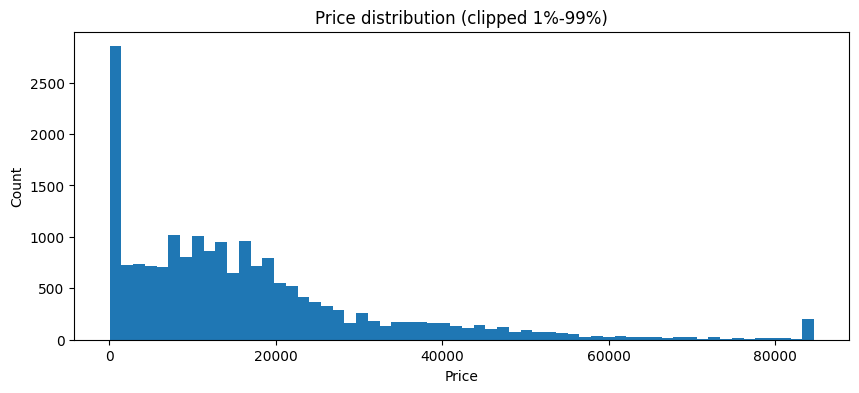

Explanation: Shows raw price distribution. Right skew indicates many cheaper cars and some expensive ones.


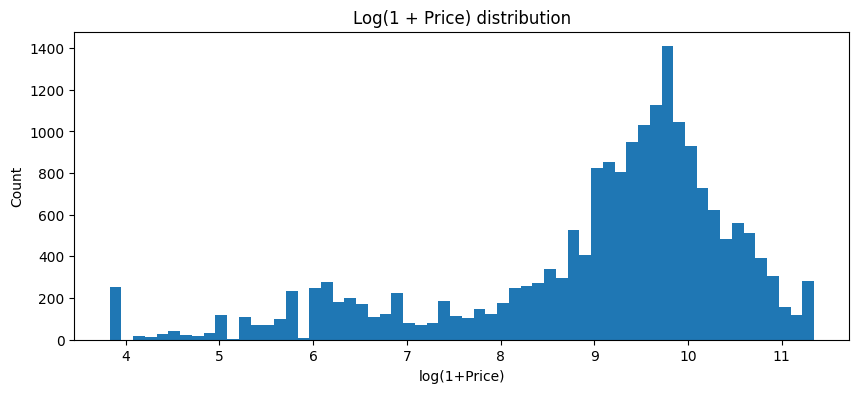

Explanation: Log transform reduces skew and helps regression models.


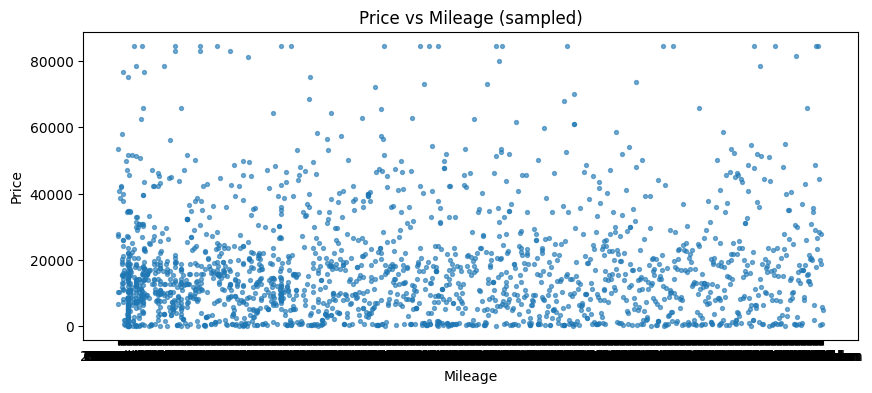

Explanation: Typically higher mileage -> lower price; scatter inspects strength of relationship.


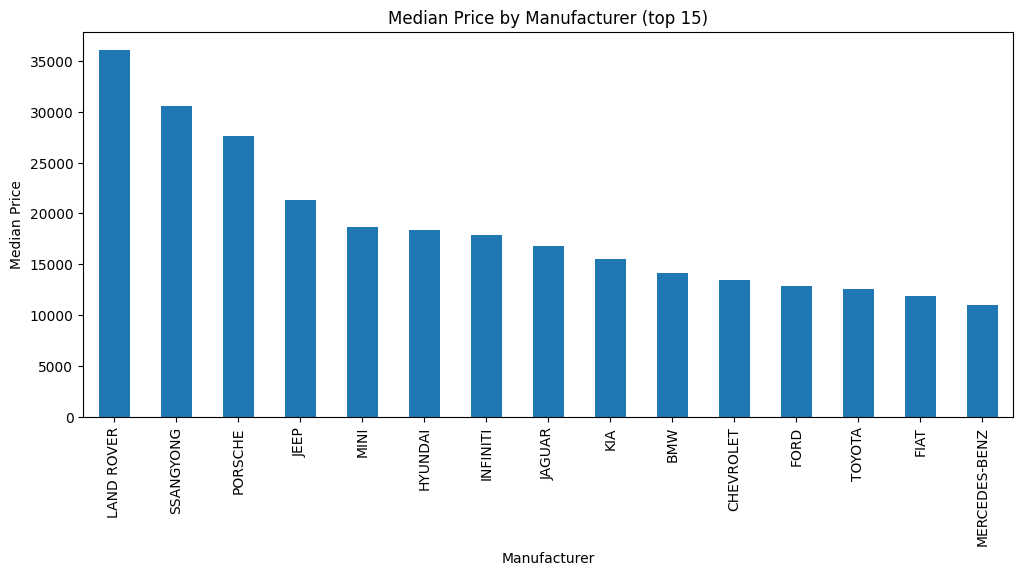

Explanation: Shows manufacturer-level price differences; useful for categorical encoding choices.


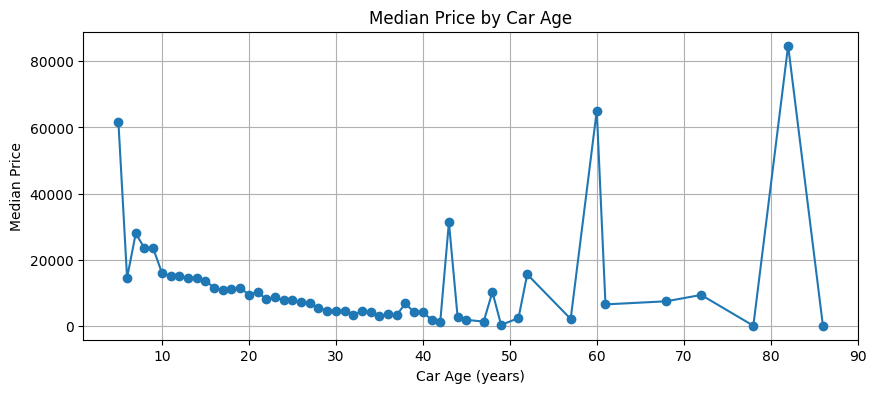

Explanation: Depreciation trend — price typically decreases as the car gets older.


In [4]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,4))
plt.hist(df[target].dropna(), bins=60)
plt.title('Price distribution (clipped 1%-99%)')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()
print('Explanation: Shows raw price distribution. Right skew indicates many cheaper cars and some expensive ones.')

plt.figure(figsize=(10,4))
plt.hist(np.log1p(df[target].dropna()), bins=60)
plt.title('Log(1 + Price) distribution')
plt.xlabel('log(1+Price)')
plt.ylabel('Count')
plt.show()
print('Explanation: Log transform reduces skew and helps regression models.')

if 'Mileage' in df.columns:
    sample = df.sample(min(2000, len(df)), random_state=42)
    plt.figure(figsize=(10,4))
    plt.scatter(sample['Mileage'], sample[target], s=8, alpha=0.6)
    plt.title('Price vs Mileage (sampled)')
    plt.xlabel('Mileage')
    plt.ylabel('Price')
    plt.show()
    print('Explanation: Typically higher mileage -> lower price; scatter inspects strength of relationship.')

if 'Manufacturer_reduced' in df.columns:
    manu_mean = df.groupby('Manufacturer_reduced')[target].median().sort_values(ascending=False).head(15)
    plt.figure(figsize=(12,5))
    manu_mean.plot(kind='bar')
    plt.title('Median Price by Manufacturer (top 15)')
    plt.ylabel('Median Price')
    plt.xlabel('Manufacturer')
    plt.show()
    print('Explanation: Shows manufacturer-level price differences; useful for categorical encoding choices.')

if 'Car_Age' in df.columns:
    age_agg = df.groupby('Car_Age')[target].median().reset_index()
    plt.figure(figsize=(10,4))
    plt.plot(age_agg['Car_Age'], age_agg[target], marker='o')
    plt.title('Median Price by Car Age')
    plt.xlabel('Car Age (years)')
    plt.ylabel('Median Price')
    plt.grid(True)
    plt.show()
    print('Explanation: Depreciation trend — price typically decreases as the car gets older.')

## Modeling

The modeling cell below trains a baseline linear regression and a RandomForest with a small randomized search. To run on the full dataset, set `max_rows_for_quick_run = None` in the cell.


In [5]:
# Modeling code
num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c]) and c != target]
cat_candidates = ['Manufacturer_reduced', 'Model_reduced', 'Fuel_type', 'Gear_box_type', 'Drive_wheels', 'Category', 'WheelColor']
features = num_cols + [c for c in cat_candidates if c in df.columns]
features = [f for f in features if f in df.columns]
print('Selected features:', features)

max_rows_for_quick_run = 5000
if max_rows_for_quick_run is not None and len(df) > max_rows_for_quick_run:
    df_model = df.sample(max_rows_for_quick_run, random_state=42).reset_index(drop=True)
    print('Sampled down to', max_rows_for_quick_run, 'rows for faster run')
else:
    df_model = df.copy()

df_model = df_model[features + [target]].copy()
df_model = df_model[df_model[features].isna().mean(axis=1) < 0.5]
train_df, test_df = train_test_split(df_model, test_size=0.2, random_state=42)
print('Train/test sizes:', train_df.shape, test_df.shape)

num_features = [c for c in features if pd.api.types.is_numeric_dtype(df_model[c])]
cat_features = [c for c in features if c not in num_features]
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median'))])
cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
                         ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))])
preprocessor = ColumnTransformer([('num', num_pipeline, num_features), ('cat', cat_pipeline, cat_features)])

import math

def get_X_y(df_):
    X = df_[features].copy()
    y = np.log1p(df_[target].values)
    return X, y

X_train, y_train = get_X_y(train_df)
X_test, y_test = get_X_y(test_df)

lr_pipeline = Pipeline([('pre', preprocessor), ('lr', LinearRegression())])
lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

def print_metrics(y_true, y_pred, label='Model'):
    y_true_orig = np.expm1(y_true)
    y_pred_orig = np.expm1(y_pred)
    mae = mean_absolute_error(y_true_orig, y_pred_orig)
    rmse = mean_squared_error(y_true_orig, y_pred_orig, squared=False)
    r2 = r2_score(y_true, y_pred)
    print(f"{label}: MAE={mae:,.2f}, RMSE={rmse:,.2f}, R2(on log)={r2:.4f}")

print('\nBaseline Linear Regression results:')
print_metrics(y_test, y_pred_lr, 'LinearRegression')

rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_pipeline = Pipeline([('pre', preprocessor), ('rf', rf)])
param_dist = {
    'rf__n_estimators': [50, 100, 150],
    'rf__max_depth': [6, 10, None],
    'rf__max_features': ['sqrt', 0.5],
    'rf__min_samples_split': [2, 5]
}
rs = RandomizedSearchCV(rf_pipeline, param_dist, n_iter=6, scoring='neg_mean_squared_error', cv=2, random_state=42, verbose=1)
rs.fit(X_train, y_train)
print('Best params:', rs.best_params_)
best_rf = rs.best_estimator_
y_pred_rf = best_rf.predict(X_test)
print('\nRandomForest results:')
print_metrics(y_test, y_pred_rf, 'RandomForest')

num_names = num_features
cat_names = []
if len(cat_features) > 0:
    ohe = best_rf.named_steps['pre'].named_transformers_['cat'].named_steps['onehot']
    for i, cats in enumerate(ohe.categories_):
        fname = cat_features[i]
        cat_names.extend([f"{fname}__{c}" for c in cats])
feature_names = num_names + cat_names
importances = best_rf.named_steps['rf'].feature_importances_
fi_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values('importance', ascending=False)
fi_df.head(30)



Selected features: ['Levy', 'Prod_year', 'Engine_volume', 'Cylinders', 'Airbags', 'Car_Age', 'Manufacturer_reduced', 'Model_reduced', 'Fuel_type', 'Gear_box_type', 'Drive_wheels', 'Category']
Sampled down to 5000 rows for faster run
Train/test sizes: (4000, 13) (1000, 13)

Baseline Linear Regression results:
LinearRegression: MAE=9,637.50, RMSE=15,850.44, R2(on log)=0.2234
Fitting 2 folds for each of 6 candidates, totalling 12 fits
Best params: {'rf__n_estimators': 150, 'rf__min_samples_split': 5, 'rf__max_features': 0.5, 'rf__max_depth': None}

RandomForest results:
RandomForest: MAE=6,063.96, RMSE=10,838.02, R2(on log)=0.4862


,feature,importance
4,Airbags,0.194041
5,Car_Age,0.096623
0,Levy,0.090009
1,Prod_year,0.087649
64,Gear_box_type__Automatic,0.066655
2,Engine_volume,0.059345
66,Gear_box_type__Tiptronic,0.045895
60,Fuel_type__Hybrid,0.034774
3,Cylinders,0.028057
43,Model_reduced__FIT,0.023011


## Model interpretation & feature importance

`fi_df` (from the previous cell) contains features sorted by importance. Use it to explain which features most influence predictions. For deeper interpretation, use SHAP or permutation importance.
